In [194]:
# IMPORTS
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

from scipy.misc import toimage

import tensorflow as tf

import time
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
#LOAD MODEL
model_fn = './inception5h/tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [51]:
#GET LAYERS, CHANNELS
layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
filtered_layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and ('import/' and
                        ("5x5" or "3x3" or "5x5"  or "conv2d") in op.name) and "bottleneck" not in op.name]

feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layer_names]

print(filtered_layer_names)

layers = []
channels = []
target_activations = []
layer_indexes = []

global_channel_idx =0

for idx, layer_name in enumerate(layer_names):
    layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
    print(layer_name)
    layers.append(graph.get_tensor_by_name(layer_name))
    print(layers[idx].shape[3])
    
    #store the channel indexes of a layer
    layer_indexes.append(np.arange(global_channel_idx,global_channel_idx + int(layers[idx].shape[3])))
    global_channel_idx = global_channel_idx + int(layers[idx].shape[3])
    
    for channel_idx in range(0,layers[idx].shape[3]):
        channel = layers[idx][:,:,:,channel_idx]
        channels.append(channel)
        target_activations.append(tf.reduce_mean(channel))

[u'import/mixed3a_5x5_pre_relu/conv', u'import/mixed3b_5x5_pre_relu/conv', u'import/mixed4a_5x5_pre_relu/conv', u'import/mixed4b_5x5_pre_relu/conv', u'import/mixed4c_5x5_pre_relu/conv', u'import/mixed4d_5x5_pre_relu/conv', u'import/mixed4e_5x5_pre_relu/conv', u'import/mixed5a_5x5_pre_relu/conv', u'import/mixed5b_5x5_pre_relu/conv']
import/conv2d0_pre_relu:0
64
import/conv2d1_pre_relu:0
64
import/conv2d2_pre_relu:0
192
import/mixed3a_1x1_pre_relu:0
64
import/mixed3a_3x3_bottleneck_pre_relu:0
96
import/mixed3a_3x3_pre_relu:0
128
import/mixed3a_5x5_bottleneck_pre_relu:0
16
import/mixed3a_5x5_pre_relu:0
32
import/mixed3a_pool_reduce_pre_relu:0
32
import/mixed3b_1x1_pre_relu:0
128
import/mixed3b_3x3_bottleneck_pre_relu:0
128
import/mixed3b_3x3_pre_relu:0
192
import/mixed3b_5x5_bottleneck_pre_relu:0
32
import/mixed3b_5x5_pre_relu:0
96
import/mixed3b_pool_reduce_pre_relu:0
64
import/mixed4a_1x1_pre_relu:0
192
import/mixed4a_3x3_bottleneck_pre_relu:0
96
import/mixed4a_3x3_pre_relu:0
204
import

In [3]:
layer_names = [op.name for op in graph.get_operations()]
layer_types = [op.type for op in graph.get_operations()]

for i in range(0,len(layer_names)):
    print("layer name: " + layer_names[i] + " layer type: " + str(layer_types[i]))


layer name: input layer type: Placeholder
layer name: sub/y layer type: Const
layer name: sub layer type: Sub
layer name: ExpandDims/dim layer type: Const
layer name: ExpandDims layer type: ExpandDims
layer name: import/input layer type: Placeholder
layer name: import/conv2d0_w layer type: Const
layer name: import/conv2d0_b layer type: Const
layer name: import/conv2d1_w layer type: Const
layer name: import/conv2d1_b layer type: Const
layer name: import/conv2d2_w layer type: Const
layer name: import/conv2d2_b layer type: Const
layer name: import/mixed3a_1x1_w layer type: Const
layer name: import/mixed3a_1x1_b layer type: Const
layer name: import/mixed3a_3x3_bottleneck_w layer type: Const
layer name: import/mixed3a_3x3_bottleneck_b layer type: Const
layer name: import/mixed3a_3x3_w layer type: Const
layer name: import/mixed3a_3x3_b layer type: Const
layer name: import/mixed3a_5x5_bottleneck_w layer type: Const
layer name: import/mixed3a_5x5_bottleneck_b layer type: Const
layer name: impo

In [134]:
# TEST - GET PREDICTION

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]
#layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

layer_name = layer_names[0]
layer_name = "import/output2"

print(layer_name)
#layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
layer_name = str(layer_name + ":0") #remove the "/conv" part, and add ":0"
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

#img = np.random.uniform(size=(224,224,3)) + 100.0
img = load_image("/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/ILSVRC2012_val_00050000.JPEG")
activations = sess.run(target_activations, {t_input:img})
activations

import/output2
import/output2:0
Tensor("import/output2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)


array([[2.6063701e-05, 5.5567518e-05, 1.4288889e-04, ..., 2.6061787e-05,
        2.6064819e-05, 2.6063553e-05],
       [1.1787291e-05, 7.5461510e-05, 1.5134634e-04, ..., 1.1786415e-05,
        1.1787774e-05, 1.1787212e-05],
       [3.8253575e-06, 6.7313777e-05, 9.6792537e-05, ..., 3.8250728e-06,
        3.8255180e-06, 3.8253356e-06],
       ...,
       [1.0512800e-09, 1.0109955e-07, 1.2947408e-08, ..., 1.0512037e-09,
        1.0513261e-09, 1.0512740e-09],
       [1.3573810e-09, 6.8309078e-08, 1.8532976e-08, ..., 1.3572825e-09,
        1.3574404e-09, 1.3573731e-09],
       [1.0328166e-08, 2.0909830e-07, 1.7736924e-07, ..., 1.0327398e-08,
        1.0328599e-08, 1.0328107e-08]], dtype=float32)

In [3]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [4]:
def convert2time(time_sec):
    sec = time_sec%60
    minute = (time_sec/60)%60
    hour = (time_sec/3600)%60
    
    return str(hour) + ":" + str(minute) + ":" + str(sec)

In [352]:
#GET ACTIVATIONS

nbr_samples = 50000
nbr_classes = 1000
nbr_channels = len(channels)

saveFrequency = 100

#img_dir = os.path.join( "E:", "PPKE", "Diplomamunka","adatbazisok","ImageNet","ILSVRC2012_img_val")
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

all_activation = np.zeros((nbr_samples,nbr_channels))

img_idx=0

for filename in os.listdir(img_dir):
    start = time.time()
    img = load_image(os.path.join(img_dir,filename))
    if len(img.shape)!=3: # if not a color image
        img_idx +=1
        continue

    activations = sess.run(target_activations, {t_input:img})   
    all_activation[img_idx,:] = activations
    end = time.time()
    remaningTime = convert2time(int((end - start)*(nbr_samples-img_idx)))
    
    print("Image: " + str(img_idx+1) + "/" + str(nbr_samples) + "   Remaning time: " +  remaningTime,end="\r")

    if (img_idx%saveFrequency)==0 and img_idx!=0:
        np.savetxt("./activations/" +str(img_idx) + ".txt", all_activation[img_idx-saveFrequency:img_idx,:], delimiter=',')
    
    img_idx +=1

KeyboardInterrupt: 

In [119]:
#GET PREDICTIONS

nbr_samples = 50000

img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"
all_predictions = np.zeros((nbr_samples))

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]

layer_name = layer_names[2] #3rd softmax layer
print(layer_name)
layer_name = str(layer_name + ":0")
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

img_idx=0

for filename in os.listdir(img_dir):  
    
    img_noise = np.random.uniform(size=(224,224,3)) + 100.0
    img = load_image(os.path.join(img_dir,filename))
    print(img.shape)

    if len(img.shape)!=3: # if not a color image
        img_idx +=1
        continue
    
    start = time.time()
    activations = sess.run(target_activations, {t_input:img_noise})
    end = time.time()
    print("sess run: " + str(end - start))
    print(activations.shape)
    for i in range(0,80):
        print(str(sum(activations[i,:])))
    print(str(activations))
    
    #all_predictions[img_idx] = activations
    plt.plot(np.matrix.transpose(activations))
    img_idx +=1
    input("kaja")

import/softmax2
import/softmax2:0
Tensor("import/softmax2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)
(500, 420, 3)
sess run: 0.0299510955811
(1, 1008)
1.0000000853909796


IndexError: index 1 is out of bounds for axis 0 with size 1

(80, 1008)
(1008,)
774


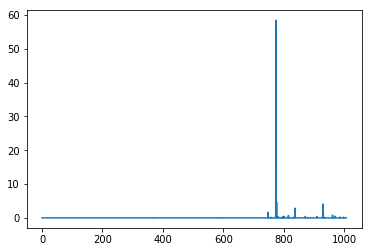

In [115]:

print(activations.shape)
sumactivations = activations.sum(axis=0)
print(sumactivations.shape)
print(np.argmax(sumactivations))
plt.plot(np.matrix.transpose(sumactivations))

In [76]:
activations.shape

(1, 1008)

In [51]:
print(all_activation[19877,:])
np.savetxt('19877tol.txt', all_activation[19877:,:], delimiter=',')

[-12.74092102  -6.56845713  -4.76647758 ...,  -3.17103529  -8.28925228
 -19.17745972]


In [5]:
#LOAD ACTIVATION ARRAYS
import numpy as np
a = np.loadtxt('19875ig.txt', delimiter=',')
print("Loading of the first 20K activations is done.")
b = np.loadtxt('19877tol.txt', delimiter=',')
print("Loading of all activations is done.")
all_activation = np.concatenate((a[:19877:],b[:,:]),axis=0) #the last two elements of a is all 0.
all_activation.shape

Loading of the first 20K activations is done.
Loading of all activations is done.


(50000, 7548)

In [354]:
all_activation_original = all_activation

In [7]:
#LOAD GROUND TRUTH LABELS and the class names
grountTruth = np.loadtxt('ILSVRC2012_validation_ground_truth.txt')
grountTruth.shape

with open('inception5h/imagenet_comp_graph_label_strings.txt') as f:
    classNames = f.read().splitlines() 

In [371]:
#GET FIRST X MAXIMUM ACTIVATIONS OF EVERY CHANNELS
import matplotlib.pyplot as plt

nbr_classes = 1000
nbrMaxActivations = 50000


topActivationsOfChannels = np.zeros((all_activation.shape[1],nbr_classes))
mostActivations = np.zeros((all_activation.shape[1]))

for channelNbr in range(0,all_activation.shape[1]):
    #activatioons of a particular channel
    channelActivations = all_activation[:,channelNbr]
    #top nbrMaxActivations activations of a particular channel
    maxActivations = np.sort(channelActivations)[-nbrMaxActivations:]
    #image indexes of the top nbrMaxActivations activations of a particular channel
    maxActivationIndexes = np.argsort(channelActivations)[-nbrMaxActivations:]
    
    #classes of the top nbrMaxActivations activations of a particular channel
    maxActivationClasses = grountTruth[maxActivationIndexes]
    
    for activationIdx in range(0,nbrMaxActivations):
        #get class index of an activation
        classIdx = int(maxActivationClasses[activationIdx])
        #get the size of an activation
        activation = maxActivations[activationIdx]
        #store the weighted class activation
        topActivationsOfChannels[channelNbr,classIdx-1] += activation
    
    
    classActivations,bins = np.histogram(maxActivationClasses,bins=nbr_classes)
    print("Channel number: " + str(channelNbr) + " Most activation in class: " + str(max(classActivations)))
    
    mostActivations[channelNbr] = max(classActivations)        

Channel number: 0 Most activation in class: 50
Channel number: 1 Most activation in class: 50
Channel number: 2 Most activation in class: 50
Channel number: 3 Most activation in class: 50
Channel number: 4 Most activation in class: 50
Channel number: 5 Most activation in class: 50
Channel number: 6 Most activation in class: 50
Channel number: 7 Most activation in class: 50
Channel number: 8 Most activation in class: 50
Channel number: 9 Most activation in class: 50
Channel number: 10 Most activation in class: 50
Channel number: 11 Most activation in class: 50
Channel number: 12 Most activation in class: 50
Channel number: 13 Most activation in class: 50
Channel number: 14 Most activation in class: 50
Channel number: 15 Most activation in class: 50
Channel number: 16 Most activation in class: 50
Channel number: 17 Most activation in class: 50
Channel number: 18 Most activation in class: 50
Channel number: 19 Most activation in class: 50
Channel number: 20 Most activation in class: 50
Ch

KeyboardInterrupt: 

[723 358 712]


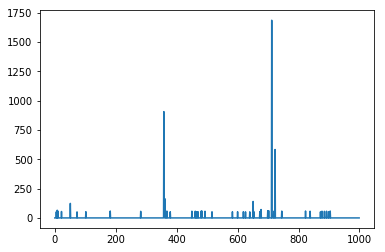

In [366]:
#np.max(channelConfusionMatrixes[99,101:,0])
#topActivationsOfChannels[0,:]
'''
print(np.argmax(topActivationsOfChannels[609,:]))

print(layer_indexes[6][1])



print(topActivationsOfChannels[609,2])
print(topActivationsOfChannels[609,20])
print(channelConfusionMatrixes[2,20,1])
'''
plt.plot(topActivationsOfChannels[4460,:])

print(np.argsort(topActivationsOfChannels[4460,:])[-3:])

#toimage(channelConfusionMatrixes[:,:,4]).show()
#print(np.count_nonzero(channelConfusionMatrixes[:,:,:]))

[723 358 712]


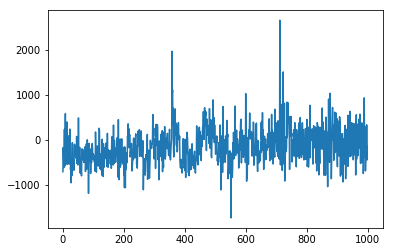

In [369]:
plt.plot(topActivationsOfChannels[4460,:])

print(np.argsort(topActivationsOfChannels[4460,:])[-3:])

In [367]:
#GET CLASS NAMES
classIndex = 358
print(classNames[classIndex])
classIndex = 712
print(classNames[classIndex])

yellow lady's slipper
fountain


In [344]:
#CALCULATE CLASS-SIMILIRATY CONFUSION MATRIX FOR CHANNELS

layer = 50

channelConfusionMatrixes = np.zeros((nbr_classes,nbr_classes,len(layer_indexes[layer])))

for confMatrixIdx,channelIdx in enumerate(layer_indexes[layer]):
    print("channel: " + str(confMatrixIdx+1) + "/" + str(len(layer_indexes[layer])),end='\r')
    for class1 in range(0,nbr_classes-1):
        for class2 in range(class1+1,nbr_classes):
            biggerActivation = max(topActivationsOfChannels[channelIdx,class1],topActivationsOfChannels[channelIdx,class2])
            smallerActivation = min(topActivationsOfChannels[channelIdx,class1],topActivationsOfChannels[channelIdx,class2])
            
            if smallerActivation !=0:
                #store the ratio of the two classes' activation
                channelConfusionMatrixes[class1,class2,confMatrixIdx] = smallerActivation/biggerActivation
                #store the bigger activation as weight
                channelConfusionMatrixes[class2,class1,confMatrixIdx] = biggerActivation

In [345]:
#AGGREGATE THE CLASS-SIMILIRATY CONFUSION MATRIXES IN THE LAYER
print("Aggregate the channel confusion matrixes \n")

layerConfusionMatrix = np.zeros((nbr_classes,nbr_classes))

for class1 in range(0,nbr_classes-1):
    for class2 in range(class1+1,nbr_classes):
        sumBiggerActivations = np.sum(channelConfusionMatrixes[class2,class1,:])
        if sumBiggerActivations !=0:
            classRatio = 0
            for confMatrixIdx in range(0,channelConfusionMatrixes.shape[2]):
                classRatio += channelConfusionMatrixes[class2,class1,confMatrixIdx]/sumBiggerActivations*channelConfusionMatrixes[class1,class2,confMatrixIdx]
            layerConfusionMatrix[class1,class2] = classRatio
            layerConfusionMatrix[class2,class1] = sumBiggerActivations

    
toimage(layerConfusionMatrix[:,:]).show()
print(layerConfusionMatrix)

Aggregate the channel confusion matrixes 

[[0.00000000e+00 2.91708696e-01 2.26379521e-01 ... 4.32593893e-01
  2.80289823e-01 3.18233440e-01]
 [3.59132179e+03 0.00000000e+00 3.27232335e-01 ... 3.33232857e-01
  1.76904518e-01 2.74706170e-01]
 [6.78590924e+03 6.85201165e+03 0.00000000e+00 ... 5.62884579e-01
  6.40122014e-01 3.88292646e-01]
 ...
 [9.76564426e+02 1.16023327e+03 6.52731037e+02 ... 0.00000000e+00
  2.09600630e-01 3.64021594e-01]
 [1.56964738e+03 1.94453730e+03 1.00735432e+03 ... 3.17559310e+03
  0.00000000e+00 4.52136541e-01]
 [1.04696645e+03 1.71729901e+03 1.11291429e+03 ... 1.48992426e+03
  1.85469625e+03 0.00000000e+00]]


In [370]:
#GET CONNECTION STATISTIC BASED ON THE LAYER CONFLUENCE MATRIX
np.count_nonzero(layerConfusionMatrix)

connectionStatistic = []

for class1 in range(0,nbr_classes-1):
    for class2 in range(class1+1,nbr_classes):
        if layerConfusionMatrix[class1,class2]!=0:
            connectionStatistic.append([class1,class2,layerConfusionMatrix[class1,class2],layerConfusionMatrix[class2,class1]])
            #print(str(class1) + " " + str(class2) + " " + str(layerConfusionMatrix[class1,class2]) + " " + str(layerConfusionMatrix[class2,class1]))


def takeSecond(elem):
    return elem[3]

# sort list with key
connectionStatistic.sort(key=takeSecond,reverse=True)

            
            
for classPair in connectionStatistic:
    print(classPair, end='\n')

[181, 202, 0.33590336626008865, 41332.42062187195]
[202, 208, 0.3310922251179873, 39564.22854042053]
[27, 202, 0.32832789686418173, 38689.27062416077]
[60, 202, 0.27774025242944433, 38231.10361289978]
[27, 208, 0.24853843106623752, 37925.536628723145]
[659, 914, 0.35281662176068873, 36747.55913925171]
[550, 659, 0.2744963447304922, 35433.499044418335]
[121, 202, 0.44806637448106706, 35190.568490982056]
[66, 202, 0.3065676672291041, 34840.686305999756]
[27, 60, 0.3164204179788359, 34589.346323013306]
[84, 202, 0.30615142811669876, 34515.99230957031]
[27, 181, 0.3184418482482839, 34332.11457824707]
[66, 208, 0.21156038686809392, 34321.76842498779]
[659, 928, 0.4245956707571851, 32777.81296539307]
[57, 202, 0.2691331364240923, 32726.824237823486]
[66, 181, 0.24829350699375385, 32680.298643112183]
[198, 202, 0.4577861612369266, 32592.89706802368]
[659, 913, 0.29193824433396093, 32324.272876739502]
[27, 84, 0.2687169002201085, 31986.742078781128]
[60, 181, 0.3853733508606777, 31878.17348480

KeyboardInterrupt: 

Layer 0 mostActivations: 8.2421875
Layer 1 mostActivations: 5.7421875
Layer 2 mostActivations: 5.5703125
Layer 3 mostActivations: 6.9765625
Layer 4 mostActivations: 6.453125
Layer 5 mostActivations: 6.3984375
Layer 6 mostActivations: 7.453125
Layer 7 mostActivations: 6.265625
Layer 8 mostActivations: 5.90625
Layer 9 mostActivations: 4.1796875
Layer 10 mostActivations: 8.0859375
Layer 11 mostActivations: 8.1171875
Layer 12 mostActivations: 7.078125
Layer 13 mostActivations: 7.1015625
Layer 14 mostActivations: 6.59375
Layer 15 mostActivations: 8.375
Layer 16 mostActivations: 9.015625
Layer 17 mostActivations: 8.7109375
Layer 18 mostActivations: 9.3984375
Layer 19 mostActivations: 7.9140625
Layer 20 mostActivations: 9.3125
Layer 21 mostActivations: 9.234375
Layer 22 mostActivations: 9.0078125
Layer 23 mostActivations: 10.03125
Layer 24 mostActivations: 8.9296875
Layer 25 mostActivations: 10.5859375
Layer 26 mostActivations: 10.53125
Layer 27 mostActivations: 10.4765625
Layer 28 mostActiva

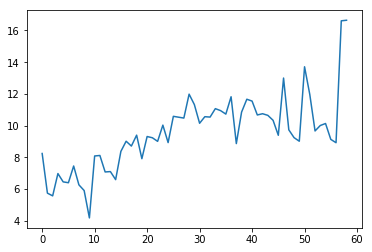

In [102]:
#MOST ACTIVATIONS IN LAYERS

#plt.plot(mostActivations)

mostActivations_layers = np.zeros(len(layers))

channelIdx = 0
for layerIndx in range(0,len(layers)):
    nbrOfChannels = int(layers[idx].shape[3])
    mostActivations_layers[layerIndx] = np.average(mostActivations[channelIdx:(channelIdx+nbrOfChannels)])
    channelIdx +=nbrOfChannels
    print("Layer " + str(layerIndx) + " mostActivations: " + str(mostActivations_layers[layerIndx]))

plt.plot(mostActivations_layers)

In [101]:
#GET X% OF THE MAXIMUM ACTIVATIONS OF A CHANNEL
import matplotlib.pyplot as plt

nbr_classes = 1000
activationPercentThr = 0.9

topActivationsOfChannels = []
splitPoints = np.zeros((all_activation.shape[1]))

for channelNbr in range(0,all_activation.shape[1]):

    channelActivations = all_activation[:,channelNbr]
    maxActivations = np.sort(channelActivations)[::-1]
    maxActivationsIndexes = np.argsort(channelActivations)
    
    maxActivations[np.where(maxActivations<0)] = 0
    
    splitPoint = 1
    while np.sum(maxActivations[:splitPoint])/np.sum(maxActivations)<activationPercentThr:
        splitPoint += 1
        
    print("Splitpoint: " + str(splitPoint))
    splitPoints[channelNbr] = splitPoint

    maxActivationClasses = grountTruth[maxActivationsIndexes[:splitPoint]]
    
    classActivations,bins = np.histogram(maxActivationClasses,bins=nbr_classes)
    print("Channel number: " + str(channelNbr) + " Max activation class: " + str(max(classActivations)))
       
        

Splitpoint: 18563
Channel number: 0 Max activation class: 46
Splitpoint: 18696
Channel number: 1 Max activation class: 45
Splitpoint: 19256
Channel number: 2 Max activation class: 39
Splitpoint: 14763
Channel number: 3 Max activation class: 46
Splitpoint: 16383
Channel number: 4 Max activation class: 45
Splitpoint: 17758
Channel number: 5 Max activation class: 45
Splitpoint: 22796
Channel number: 6 Max activation class: 50
Splitpoint: 19532
Channel number: 7 Max activation class: 43
Splitpoint: 14830
Channel number: 8 Max activation class: 41
Splitpoint: 17539
Channel number: 9 Max activation class: 50
Splitpoint: 12953
Channel number: 10 Max activation class: 48
Splitpoint: 23404
Channel number: 11 Max activation class: 50
Splitpoint: 13341
Channel number: 12 Max activation class: 48
Splitpoint: 23904
Channel number: 13 Max activation class: 50
Splitpoint: 19715
Channel number: 14 Max activation class: 46
Splitpoint: 11353
Channel number: 15 Max activation class: 35
Splitpoint: 18694


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Splitpoint: 13238
Channel number: 132 Max activation class: 44
Splitpoint: 61
Channel number: 133 Max activation class: 3
Splitpoint: 3124
Channel number: 134 Max activation class: 31
Splitpoint: 1
Channel number: 135 Max activation class: 1
Splitpoint: 1
Channel number: 136 Max activation class: 1
Splitpoint: 1958
Channel number: 137 Max activation class: 19
Splitpoint: 55
Channel number: 138 Max activation class: 3
Splitpoint: 9
Channel number: 139 Max activation class: 1
Splitpoint: 8537
Channel number: 140 Max activation class: 36
Splitpoint: 855
Channel number: 141 Max activation class: 19
Splitpoint: 48
Channel number: 142 Max activation class: 6
Splitpoint: 3
Channel number: 143 Max activation class: 1
Splitpoint: 126
Channel number: 144 Max activation class: 7
Splitpoint: 2
Channel number: 145 Max activation class: 2
Splitpoint: 2
Channel number: 146 Max activation class: 1
Splitpoint: 93
Channel number: 147 Max activation class: 3
Splitpoint: 6
Channel number: 148 Max activati

Splitpoint: 15887
Channel number: 271 Max activation class: 47
Splitpoint: 1687
Channel number: 272 Max activation class: 13
Splitpoint: 4
Channel number: 273 Max activation class: 1
Splitpoint: 1
Channel number: 274 Max activation class: 1
Splitpoint: 1028
Channel number: 275 Max activation class: 20
Splitpoint: 10096
Channel number: 276 Max activation class: 50
Splitpoint: 1
Channel number: 277 Max activation class: 1
Splitpoint: 428
Channel number: 278 Max activation class: 33
Splitpoint: 3
Channel number: 279 Max activation class: 1
Splitpoint: 1
Channel number: 280 Max activation class: 1
Splitpoint: 4
Channel number: 281 Max activation class: 1
Splitpoint: 1
Channel number: 282 Max activation class: 1
Splitpoint: 3036
Channel number: 283 Max activation class: 43
Splitpoint: 20
Channel number: 284 Max activation class: 2
Splitpoint: 74
Channel number: 285 Max activation class: 4
Splitpoint: 881
Channel number: 286 Max activation class: 11
Splitpoint: 18810
Channel number: 287 Max 

Splitpoint: 11758
Channel number: 405 Max activation class: 44
Splitpoint: 31133
Channel number: 406 Max activation class: 50
Splitpoint: 27346
Channel number: 407 Max activation class: 50
Splitpoint: 31961
Channel number: 408 Max activation class: 50
Splitpoint: 23768
Channel number: 409 Max activation class: 49
Splitpoint: 40093
Channel number: 410 Max activation class: 50
Splitpoint: 14588
Channel number: 411 Max activation class: 50
Splitpoint: 28640
Channel number: 412 Max activation class: 50
Splitpoint: 2056
Channel number: 413 Max activation class: 22
Splitpoint: 31623
Channel number: 414 Max activation class: 50
Splitpoint: 30847
Channel number: 415 Max activation class: 50
Splitpoint: 31961
Channel number: 416 Max activation class: 50
Splitpoint: 36116
Channel number: 417 Max activation class: 50
Splitpoint: 36560
Channel number: 418 Max activation class: 50
Splitpoint: 34468
Channel number: 419 Max activation class: 50
Splitpoint: 31446
Channel number: 420 Max activation cla

Splitpoint: 28409
Channel number: 536 Max activation class: 50
Splitpoint: 6045
Channel number: 537 Max activation class: 43
Splitpoint: 19761
Channel number: 538 Max activation class: 37
Splitpoint: 20364
Channel number: 539 Max activation class: 50
Splitpoint: 24241
Channel number: 540 Max activation class: 50
Splitpoint: 21500
Channel number: 541 Max activation class: 50
Splitpoint: 35601
Channel number: 542 Max activation class: 50
Splitpoint: 31728
Channel number: 543 Max activation class: 49
Splitpoint: 13138
Channel number: 544 Max activation class: 49
Splitpoint: 2261
Channel number: 545 Max activation class: 13
Splitpoint: 3438
Channel number: 546 Max activation class: 27
Splitpoint: 15589
Channel number: 547 Max activation class: 42
Splitpoint: 34621
Channel number: 548 Max activation class: 50
Splitpoint: 24580
Channel number: 549 Max activation class: 47
Splitpoint: 3756
Channel number: 550 Max activation class: 24
Splitpoint: 29658
Channel number: 551 Max activation class:

Splitpoint: 31816
Channel number: 667 Max activation class: 50
Splitpoint: 16326
Channel number: 668 Max activation class: 45
Splitpoint: 28340
Channel number: 669 Max activation class: 50
Splitpoint: 26945
Channel number: 670 Max activation class: 50
Splitpoint: 15446
Channel number: 671 Max activation class: 46
Splitpoint: 17560
Channel number: 672 Max activation class: 36
Splitpoint: 29477
Channel number: 673 Max activation class: 50
Splitpoint: 16254
Channel number: 674 Max activation class: 40
Splitpoint: 26760
Channel number: 675 Max activation class: 50
Splitpoint: 28324
Channel number: 676 Max activation class: 50
Splitpoint: 25026
Channel number: 677 Max activation class: 49
Splitpoint: 32201
Channel number: 678 Max activation class: 50
Splitpoint: 19556
Channel number: 679 Max activation class: 50
Splitpoint: 23895
Channel number: 680 Max activation class: 49
Splitpoint: 20230
Channel number: 681 Max activation class: 39
Splitpoint: 34059
Channel number: 682 Max activation cl

Splitpoint: 2901
Channel number: 801 Max activation class: 25
Splitpoint: 7638
Channel number: 802 Max activation class: 43
Splitpoint: 13070
Channel number: 803 Max activation class: 45
Splitpoint: 59
Channel number: 804 Max activation class: 5
Splitpoint: 10385
Channel number: 805 Max activation class: 43
Splitpoint: 7952
Channel number: 806 Max activation class: 34
Splitpoint: 10027
Channel number: 807 Max activation class: 40
Splitpoint: 1819
Channel number: 808 Max activation class: 19
Splitpoint: 2788
Channel number: 809 Max activation class: 35
Splitpoint: 2060
Channel number: 810 Max activation class: 21
Splitpoint: 3921
Channel number: 811 Max activation class: 38
Splitpoint: 6114
Channel number: 812 Max activation class: 48
Splitpoint: 1772
Channel number: 813 Max activation class: 36
Splitpoint: 26540
Channel number: 814 Max activation class: 48
Splitpoint: 15860
Channel number: 815 Max activation class: 47
Splitpoint: 6580
Channel number: 816 Max activation class: 38
Splitp

Splitpoint: 22474
Channel number: 932 Max activation class: 49
Splitpoint: 6119
Channel number: 933 Max activation class: 42
Splitpoint: 11269
Channel number: 934 Max activation class: 48
Splitpoint: 31376
Channel number: 935 Max activation class: 50
Splitpoint: 39392
Channel number: 936 Max activation class: 50
Splitpoint: 4497
Channel number: 937 Max activation class: 33
Splitpoint: 16806
Channel number: 938 Max activation class: 50
Splitpoint: 6616
Channel number: 939 Max activation class: 34
Splitpoint: 21090
Channel number: 940 Max activation class: 50
Splitpoint: 32581
Channel number: 941 Max activation class: 50
Splitpoint: 3313
Channel number: 942 Max activation class: 32
Splitpoint: 8408
Channel number: 943 Max activation class: 33
Splitpoint: 9518
Channel number: 944 Max activation class: 44
Splitpoint: 22
Channel number: 945 Max activation class: 5
Splitpoint: 7
Channel number: 946 Max activation class: 5
Splitpoint: 179
Channel number: 947 Max activation class: 11
Splitpoin

Splitpoint: 5616
Channel number: 1068 Max activation class: 43
Splitpoint: 42
Channel number: 1069 Max activation class: 12
Splitpoint: 1
Channel number: 1070 Max activation class: 1
Splitpoint: 20
Channel number: 1071 Max activation class: 2
Splitpoint: 3281
Channel number: 1072 Max activation class: 38
Splitpoint: 1
Channel number: 1073 Max activation class: 1
Splitpoint: 181
Channel number: 1074 Max activation class: 18
Splitpoint: 1028
Channel number: 1075 Max activation class: 19
Splitpoint: 12
Channel number: 1076 Max activation class: 5
Splitpoint: 3
Channel number: 1077 Max activation class: 1
Splitpoint: 692
Channel number: 1078 Max activation class: 8
Splitpoint: 48
Channel number: 1079 Max activation class: 3
Splitpoint: 104
Channel number: 1080 Max activation class: 3
Splitpoint: 47
Channel number: 1081 Max activation class: 4
Splitpoint: 14
Channel number: 1082 Max activation class: 2
Splitpoint: 3353
Channel number: 1083 Max activation class: 33
Splitpoint: 4
Channel numb

Splitpoint: 83
Channel number: 1209 Max activation class: 6
Splitpoint: 2
Channel number: 1210 Max activation class: 1
Splitpoint: 1
Channel number: 1211 Max activation class: 1
Splitpoint: 24
Channel number: 1212 Max activation class: 5
Splitpoint: 5
Channel number: 1213 Max activation class: 1
Splitpoint: 1
Channel number: 1214 Max activation class: 1
Splitpoint: 19
Channel number: 1215 Max activation class: 2
Splitpoint: 1
Channel number: 1216 Max activation class: 1
Splitpoint: 1
Channel number: 1217 Max activation class: 1
Splitpoint: 5
Channel number: 1218 Max activation class: 4
Splitpoint: 88
Channel number: 1219 Max activation class: 4
Splitpoint: 20188
Channel number: 1220 Max activation class: 48
Splitpoint: 1345
Channel number: 1221 Max activation class: 17
Splitpoint: 1
Channel number: 1222 Max activation class: 1
Splitpoint: 3
Channel number: 1223 Max activation class: 2
Splitpoint: 2
Channel number: 1224 Max activation class: 1
Splitpoint: 1084
Channel number: 1225 Max a

Splitpoint: 13503
Channel number: 1342 Max activation class: 39
Splitpoint: 5666
Channel number: 1343 Max activation class: 40
Splitpoint: 5165
Channel number: 1344 Max activation class: 48
Splitpoint: 18542
Channel number: 1345 Max activation class: 50
Splitpoint: 6538
Channel number: 1346 Max activation class: 30
Splitpoint: 8295
Channel number: 1347 Max activation class: 42
Splitpoint: 9683
Channel number: 1348 Max activation class: 40
Splitpoint: 4724
Channel number: 1349 Max activation class: 30
Splitpoint: 3520
Channel number: 1350 Max activation class: 29
Splitpoint: 1157
Channel number: 1351 Max activation class: 18
Splitpoint: 12505
Channel number: 1352 Max activation class: 39
Splitpoint: 10794
Channel number: 1353 Max activation class: 47
Splitpoint: 12055
Channel number: 1354 Max activation class: 46
Splitpoint: 638
Channel number: 1355 Max activation class: 17
Splitpoint: 3297
Channel number: 1356 Max activation class: 26
Splitpoint: 21241
Channel number: 1357 Max activati

Splitpoint: 14394
Channel number: 1472 Max activation class: 45
Splitpoint: 20610
Channel number: 1473 Max activation class: 49
Splitpoint: 4143
Channel number: 1474 Max activation class: 45
Splitpoint: 8934
Channel number: 1475 Max activation class: 41
Splitpoint: 22722
Channel number: 1476 Max activation class: 47
Splitpoint: 6599
Channel number: 1477 Max activation class: 42
Splitpoint: 30495
Channel number: 1478 Max activation class: 50
Splitpoint: 10327
Channel number: 1479 Max activation class: 47
Splitpoint: 8673
Channel number: 1480 Max activation class: 49
Splitpoint: 3401
Channel number: 1481 Max activation class: 30
Splitpoint: 5319
Channel number: 1482 Max activation class: 25
Splitpoint: 5135
Channel number: 1483 Max activation class: 34
Splitpoint: 7226
Channel number: 1484 Max activation class: 32
Splitpoint: 4295
Channel number: 1485 Max activation class: 32
Splitpoint: 12187
Channel number: 1486 Max activation class: 46
Splitpoint: 36486
Channel number: 1487 Max activa

Splitpoint: 28417
Channel number: 1601 Max activation class: 49
Splitpoint: 20073
Channel number: 1602 Max activation class: 47
Splitpoint: 38952
Channel number: 1603 Max activation class: 50
Splitpoint: 32597
Channel number: 1604 Max activation class: 50
Splitpoint: 29575
Channel number: 1605 Max activation class: 50
Splitpoint: 40436
Channel number: 1606 Max activation class: 50
Splitpoint: 20263
Channel number: 1607 Max activation class: 50
Splitpoint: 22283
Channel number: 1608 Max activation class: 50
Splitpoint: 34140
Channel number: 1609 Max activation class: 50
Splitpoint: 32912
Channel number: 1610 Max activation class: 50
Splitpoint: 37683
Channel number: 1611 Max activation class: 50
Splitpoint: 16841
Channel number: 1612 Max activation class: 49
Splitpoint: 40686
Channel number: 1613 Max activation class: 50
Splitpoint: 22498
Channel number: 1614 Max activation class: 50
Splitpoint: 20706
Channel number: 1615 Max activation class: 50
Splitpoint: 2211
Channel number: 1616 Ma

Splitpoint: 35
Channel number: 1742 Max activation class: 3
Splitpoint: 6645
Channel number: 1743 Max activation class: 34
Splitpoint: 2
Channel number: 1744 Max activation class: 1
Splitpoint: 13331
Channel number: 1745 Max activation class: 43
Splitpoint: 55
Channel number: 1746 Max activation class: 13
Splitpoint: 1992
Channel number: 1747 Max activation class: 36
Splitpoint: 7
Channel number: 1748 Max activation class: 1
Splitpoint: 1
Channel number: 1749 Max activation class: 1
Splitpoint: 5999
Channel number: 1750 Max activation class: 44
Splitpoint: 997
Channel number: 1751 Max activation class: 26
Splitpoint: 259
Channel number: 1752 Max activation class: 7
Splitpoint: 274
Channel number: 1753 Max activation class: 10
Splitpoint: 87
Channel number: 1754 Max activation class: 13
Splitpoint: 16
Channel number: 1755 Max activation class: 4
Splitpoint: 4
Channel number: 1756 Max activation class: 2
Splitpoint: 504
Channel number: 1757 Max activation class: 19
Splitpoint: 15880
Chan

Splitpoint: 3
Channel number: 1875 Max activation class: 1
Splitpoint: 23
Channel number: 1876 Max activation class: 4
Splitpoint: 32
Channel number: 1877 Max activation class: 2
Splitpoint: 8
Channel number: 1878 Max activation class: 2
Splitpoint: 30176
Channel number: 1879 Max activation class: 48
Splitpoint: 33
Channel number: 1880 Max activation class: 2
Splitpoint: 2
Channel number: 1881 Max activation class: 1
Splitpoint: 699
Channel number: 1882 Max activation class: 6
Splitpoint: 8850
Channel number: 1883 Max activation class: 44
Splitpoint: 1552
Channel number: 1884 Max activation class: 30
Splitpoint: 20984
Channel number: 1885 Max activation class: 50
Splitpoint: 2286
Channel number: 1886 Max activation class: 29
Splitpoint: 5366
Channel number: 1887 Max activation class: 32
Splitpoint: 15078
Channel number: 1888 Max activation class: 50
Splitpoint: 12149
Channel number: 1889 Max activation class: 42
Splitpoint: 16982
Channel number: 1890 Max activation class: 46
Splitpoint

Splitpoint: 27455
Channel number: 2005 Max activation class: 50
Splitpoint: 14232
Channel number: 2006 Max activation class: 45
Splitpoint: 14305
Channel number: 2007 Max activation class: 47
Splitpoint: 9142
Channel number: 2008 Max activation class: 50
Splitpoint: 18345
Channel number: 2009 Max activation class: 47
Splitpoint: 16549
Channel number: 2010 Max activation class: 47
Splitpoint: 27837
Channel number: 2011 Max activation class: 50
Splitpoint: 19502
Channel number: 2012 Max activation class: 47
Splitpoint: 15190
Channel number: 2013 Max activation class: 48
Splitpoint: 20564
Channel number: 2014 Max activation class: 49
Splitpoint: 7814
Channel number: 2015 Max activation class: 31
Splitpoint: 14482
Channel number: 2016 Max activation class: 43
Splitpoint: 11982
Channel number: 2017 Max activation class: 42
Splitpoint: 17861
Channel number: 2018 Max activation class: 49
Splitpoint: 11989
Channel number: 2019 Max activation class: 48
Splitpoint: 17938
Channel number: 2020 Max

Splitpoint: 34837
Channel number: 2134 Max activation class: 50
Splitpoint: 27877
Channel number: 2135 Max activation class: 50
Splitpoint: 33378
Channel number: 2136 Max activation class: 50
Splitpoint: 38571
Channel number: 2137 Max activation class: 50
Splitpoint: 24245
Channel number: 2138 Max activation class: 49
Splitpoint: 26214
Channel number: 2139 Max activation class: 49
Splitpoint: 29071
Channel number: 2140 Max activation class: 50
Splitpoint: 25957
Channel number: 2141 Max activation class: 50
Splitpoint: 13848
Channel number: 2142 Max activation class: 45
Splitpoint: 30658
Channel number: 2143 Max activation class: 50
Splitpoint: 29680
Channel number: 2144 Max activation class: 50
Splitpoint: 24589
Channel number: 2145 Max activation class: 50
Splitpoint: 14104
Channel number: 2146 Max activation class: 48
Splitpoint: 34326
Channel number: 2147 Max activation class: 50
Splitpoint: 32798
Channel number: 2148 Max activation class: 50
Splitpoint: 33876
Channel number: 2149 M

Splitpoint: 14945
Channel number: 2266 Max activation class: 45
Splitpoint: 86
Channel number: 2267 Max activation class: 15
Splitpoint: 90
Channel number: 2268 Max activation class: 6
Splitpoint: 2012
Channel number: 2269 Max activation class: 20
Splitpoint: 6008
Channel number: 2270 Max activation class: 38
Splitpoint: 7426
Channel number: 2271 Max activation class: 37
Splitpoint: 2709
Channel number: 2272 Max activation class: 35
Splitpoint: 1834
Channel number: 2273 Max activation class: 32
Splitpoint: 784
Channel number: 2274 Max activation class: 22
Splitpoint: 18409
Channel number: 2275 Max activation class: 46
Splitpoint: 7547
Channel number: 2276 Max activation class: 50
Splitpoint: 9071
Channel number: 2277 Max activation class: 45
Splitpoint: 2831
Channel number: 2278 Max activation class: 30
Splitpoint: 3334
Channel number: 2279 Max activation class: 31
Splitpoint: 4437
Channel number: 2280 Max activation class: 33
Splitpoint: 14828
Channel number: 2281 Max activation class

Splitpoint: 7199
Channel number: 2398 Max activation class: 49
Splitpoint: 1464
Channel number: 2399 Max activation class: 23
Splitpoint: 3991
Channel number: 2400 Max activation class: 34
Splitpoint: 13803
Channel number: 2401 Max activation class: 44
Splitpoint: 8534
Channel number: 2402 Max activation class: 49
Splitpoint: 9610
Channel number: 2403 Max activation class: 47
Splitpoint: 566
Channel number: 2404 Max activation class: 14
Splitpoint: 3314
Channel number: 2405 Max activation class: 23
Splitpoint: 4700
Channel number: 2406 Max activation class: 36
Splitpoint: 4447
Channel number: 2407 Max activation class: 31
Splitpoint: 1322
Channel number: 2408 Max activation class: 41
Splitpoint: 6137
Channel number: 2409 Max activation class: 36
Splitpoint: 7085
Channel number: 2410 Max activation class: 44
Splitpoint: 5205
Channel number: 2411 Max activation class: 39
Splitpoint: 7230
Channel number: 2412 Max activation class: 49
Splitpoint: 3309
Channel number: 2413 Max activation cl

Splitpoint: 1883
Channel number: 2529 Max activation class: 24
Splitpoint: 7559
Channel number: 2530 Max activation class: 37
Splitpoint: 8
Channel number: 2531 Max activation class: 2
Splitpoint: 4060
Channel number: 2532 Max activation class: 47
Splitpoint: 10327
Channel number: 2533 Max activation class: 45
Splitpoint: 2001
Channel number: 2534 Max activation class: 23
Splitpoint: 15314
Channel number: 2535 Max activation class: 50
Splitpoint: 9431
Channel number: 2536 Max activation class: 43
Splitpoint: 2073
Channel number: 2537 Max activation class: 37
Splitpoint: 10067
Channel number: 2538 Max activation class: 37
Splitpoint: 16192
Channel number: 2539 Max activation class: 45
Splitpoint: 11748
Channel number: 2540 Max activation class: 44
Splitpoint: 694
Channel number: 2541 Max activation class: 18
Splitpoint: 12210
Channel number: 2542 Max activation class: 46
Splitpoint: 1523
Channel number: 2543 Max activation class: 33
Splitpoint: 7095
Channel number: 2544 Max activation c

Splitpoint: 5918
Channel number: 2659 Max activation class: 50
Splitpoint: 5753
Channel number: 2660 Max activation class: 41
Splitpoint: 19545
Channel number: 2661 Max activation class: 50
Splitpoint: 9181
Channel number: 2662 Max activation class: 43
Splitpoint: 14485
Channel number: 2663 Max activation class: 49
Splitpoint: 4000
Channel number: 2664 Max activation class: 35
Splitpoint: 6105
Channel number: 2665 Max activation class: 46
Splitpoint: 20091
Channel number: 2666 Max activation class: 48
Splitpoint: 16723
Channel number: 2667 Max activation class: 49
Splitpoint: 22084
Channel number: 2668 Max activation class: 50
Splitpoint: 7897
Channel number: 2669 Max activation class: 40
Splitpoint: 16776
Channel number: 2670 Max activation class: 50
Splitpoint: 1142
Channel number: 2671 Max activation class: 16
Splitpoint: 2342
Channel number: 2672 Max activation class: 20
Splitpoint: 21951
Channel number: 2673 Max activation class: 49
Splitpoint: 2522
Channel number: 2674 Max activa

Splitpoint: 22295
Channel number: 2788 Max activation class: 50
Splitpoint: 9963
Channel number: 2789 Max activation class: 44
Splitpoint: 12936
Channel number: 2790 Max activation class: 50
Splitpoint: 23223
Channel number: 2791 Max activation class: 50
Splitpoint: 11756
Channel number: 2792 Max activation class: 44
Splitpoint: 14909
Channel number: 2793 Max activation class: 50
Splitpoint: 34459
Channel number: 2794 Max activation class: 50
Splitpoint: 26142
Channel number: 2795 Max activation class: 50
Splitpoint: 3686
Channel number: 2796 Max activation class: 40
Splitpoint: 14070
Channel number: 2797 Max activation class: 46
Splitpoint: 11818
Channel number: 2798 Max activation class: 49
Splitpoint: 18243
Channel number: 2799 Max activation class: 49
Splitpoint: 35526
Channel number: 2800 Max activation class: 50
Splitpoint: 28444
Channel number: 2801 Max activation class: 50
Splitpoint: 7411
Channel number: 2802 Max activation class: 38
Splitpoint: 23285
Channel number: 2803 Max 

Splitpoint: 11278
Channel number: 2919 Max activation class: 48
Splitpoint: 9042
Channel number: 2920 Max activation class: 44
Splitpoint: 6484
Channel number: 2921 Max activation class: 44
Splitpoint: 2302
Channel number: 2922 Max activation class: 34
Splitpoint: 8320
Channel number: 2923 Max activation class: 43
Splitpoint: 3580
Channel number: 2924 Max activation class: 39
Splitpoint: 1662
Channel number: 2925 Max activation class: 21
Splitpoint: 1301
Channel number: 2926 Max activation class: 32
Splitpoint: 4590
Channel number: 2927 Max activation class: 33
Splitpoint: 1777
Channel number: 2928 Max activation class: 26
Splitpoint: 8346
Channel number: 2929 Max activation class: 46
Splitpoint: 4342
Channel number: 2930 Max activation class: 41
Splitpoint: 1157
Channel number: 2931 Max activation class: 15
Splitpoint: 5482
Channel number: 2932 Max activation class: 36
Splitpoint: 2998
Channel number: 2933 Max activation class: 39
Splitpoint: 12212
Channel number: 2934 Max activation 

Splitpoint: 6561
Channel number: 3050 Max activation class: 46
Splitpoint: 3783
Channel number: 3051 Max activation class: 48
Splitpoint: 4556
Channel number: 3052 Max activation class: 43
Splitpoint: 4221
Channel number: 3053 Max activation class: 41
Splitpoint: 1081
Channel number: 3054 Max activation class: 30
Splitpoint: 8358
Channel number: 3055 Max activation class: 45
Splitpoint: 1598
Channel number: 3056 Max activation class: 38
Splitpoint: 245
Channel number: 3057 Max activation class: 11
Splitpoint: 5188
Channel number: 3058 Max activation class: 49
Splitpoint: 4025
Channel number: 3059 Max activation class: 41
Splitpoint: 2251
Channel number: 3060 Max activation class: 27
Splitpoint: 510
Channel number: 3061 Max activation class: 20
Splitpoint: 1639
Channel number: 3062 Max activation class: 20
Splitpoint: 532
Channel number: 3063 Max activation class: 12
Splitpoint: 12819
Channel number: 3064 Max activation class: 49
Splitpoint: 4100
Channel number: 3065 Max activation clas

Splitpoint: 11717
Channel number: 3186 Max activation class: 47
Splitpoint: 8
Channel number: 3187 Max activation class: 1
Splitpoint: 1226
Channel number: 3188 Max activation class: 16
Splitpoint: 12376
Channel number: 3189 Max activation class: 48
Splitpoint: 19163
Channel number: 3190 Max activation class: 50
Splitpoint: 10265
Channel number: 3191 Max activation class: 38
Splitpoint: 3761
Channel number: 3192 Max activation class: 43
Splitpoint: 20
Channel number: 3193 Max activation class: 1
Splitpoint: 656
Channel number: 3194 Max activation class: 17
Splitpoint: 219
Channel number: 3195 Max activation class: 10
Splitpoint: 690
Channel number: 3196 Max activation class: 27
Splitpoint: 764
Channel number: 3197 Max activation class: 19
Splitpoint: 281
Channel number: 3198 Max activation class: 19
Splitpoint: 1374
Channel number: 3199 Max activation class: 30
Splitpoint: 5036
Channel number: 3200 Max activation class: 40
Splitpoint: 6588
Channel number: 3201 Max activation class: 33


Splitpoint: 1972
Channel number: 3320 Max activation class: 21
Splitpoint: 8589
Channel number: 3321 Max activation class: 40
Splitpoint: 2268
Channel number: 3322 Max activation class: 35
Splitpoint: 4960
Channel number: 3323 Max activation class: 30
Splitpoint: 105
Channel number: 3324 Max activation class: 7
Splitpoint: 606
Channel number: 3325 Max activation class: 24
Splitpoint: 7750
Channel number: 3326 Max activation class: 39
Splitpoint: 8547
Channel number: 3327 Max activation class: 45
Splitpoint: 6103
Channel number: 3328 Max activation class: 44
Splitpoint: 2883
Channel number: 3329 Max activation class: 26
Splitpoint: 3633
Channel number: 3330 Max activation class: 45
Splitpoint: 24251
Channel number: 3331 Max activation class: 50
Splitpoint: 10177
Channel number: 3332 Max activation class: 44
Splitpoint: 1163
Channel number: 3333 Max activation class: 22
Splitpoint: 468
Channel number: 3334 Max activation class: 15
Splitpoint: 12180
Channel number: 3335 Max activation cla

Splitpoint: 12949
Channel number: 3450 Max activation class: 50
Splitpoint: 11122
Channel number: 3451 Max activation class: 44
Splitpoint: 1429
Channel number: 3452 Max activation class: 24
Splitpoint: 917
Channel number: 3453 Max activation class: 22
Splitpoint: 968
Channel number: 3454 Max activation class: 20
Splitpoint: 7751
Channel number: 3455 Max activation class: 44
Splitpoint: 1280
Channel number: 3456 Max activation class: 27
Splitpoint: 17908
Channel number: 3457 Max activation class: 50
Splitpoint: 6479
Channel number: 3458 Max activation class: 49
Splitpoint: 21787
Channel number: 3459 Max activation class: 50
Splitpoint: 274
Channel number: 3460 Max activation class: 12
Splitpoint: 12204
Channel number: 3461 Max activation class: 49
Splitpoint: 18018
Channel number: 3462 Max activation class: 50
Splitpoint: 3383
Channel number: 3463 Max activation class: 38
Splitpoint: 7998
Channel number: 3464 Max activation class: 39
Splitpoint: 502
Channel number: 3465 Max activation 

Splitpoint: 6572
Channel number: 3582 Max activation class: 45
Splitpoint: 877
Channel number: 3583 Max activation class: 22
Splitpoint: 5806
Channel number: 3584 Max activation class: 48
Splitpoint: 11125
Channel number: 3585 Max activation class: 48
Splitpoint: 80
Channel number: 3586 Max activation class: 9
Splitpoint: 246
Channel number: 3587 Max activation class: 9
Splitpoint: 834
Channel number: 3588 Max activation class: 22
Splitpoint: 280
Channel number: 3589 Max activation class: 14
Splitpoint: 4163
Channel number: 3590 Max activation class: 49
Splitpoint: 5303
Channel number: 3591 Max activation class: 39
Splitpoint: 321
Channel number: 3592 Max activation class: 10
Splitpoint: 44
Channel number: 3593 Max activation class: 3
Splitpoint: 1433
Channel number: 3594 Max activation class: 19
Splitpoint: 1256
Channel number: 3595 Max activation class: 28
Splitpoint: 138
Channel number: 3596 Max activation class: 7
Splitpoint: 1878
Channel number: 3597 Max activation class: 33
Split

Splitpoint: 2447
Channel number: 3714 Max activation class: 27
Splitpoint: 2211
Channel number: 3715 Max activation class: 33
Splitpoint: 139
Channel number: 3716 Max activation class: 10
Splitpoint: 58
Channel number: 3717 Max activation class: 9
Splitpoint: 215
Channel number: 3718 Max activation class: 11
Splitpoint: 328
Channel number: 3719 Max activation class: 13
Splitpoint: 1486
Channel number: 3720 Max activation class: 29
Splitpoint: 1745
Channel number: 3721 Max activation class: 24
Splitpoint: 25
Channel number: 3722 Max activation class: 4
Splitpoint: 751
Channel number: 3723 Max activation class: 20
Splitpoint: 8009
Channel number: 3724 Max activation class: 48
Splitpoint: 475
Channel number: 3725 Max activation class: 14
Splitpoint: 1354
Channel number: 3726 Max activation class: 24
Splitpoint: 5493
Channel number: 3727 Max activation class: 50
Splitpoint: 5771
Channel number: 3728 Max activation class: 48
Splitpoint: 11364
Channel number: 3729 Max activation class: 49
Sp

Splitpoint: 487
Channel number: 3847 Max activation class: 30
Splitpoint: 226
Channel number: 3848 Max activation class: 13
Splitpoint: 1606
Channel number: 3849 Max activation class: 19
Splitpoint: 114
Channel number: 3850 Max activation class: 3
Splitpoint: 1127
Channel number: 3851 Max activation class: 21
Splitpoint: 3483
Channel number: 3852 Max activation class: 36
Splitpoint: 53
Channel number: 3853 Max activation class: 4
Splitpoint: 1161
Channel number: 3854 Max activation class: 23
Splitpoint: 14
Channel number: 3855 Max activation class: 2
Splitpoint: 3113
Channel number: 3856 Max activation class: 37
Splitpoint: 5219
Channel number: 3857 Max activation class: 38
Splitpoint: 92
Channel number: 3858 Max activation class: 5
Splitpoint: 1293
Channel number: 3859 Max activation class: 28
Splitpoint: 485
Channel number: 3860 Max activation class: 13
Splitpoint: 24
Channel number: 3861 Max activation class: 4
Splitpoint: 5
Channel number: 3862 Max activation class: 4
Splitpoint: 3

Splitpoint: 10489
Channel number: 3981 Max activation class: 42
Splitpoint: 2196
Channel number: 3982 Max activation class: 22
Splitpoint: 9220
Channel number: 3983 Max activation class: 36
Splitpoint: 6694
Channel number: 3984 Max activation class: 45
Splitpoint: 2035
Channel number: 3985 Max activation class: 42
Splitpoint: 10555
Channel number: 3986 Max activation class: 45
Splitpoint: 332
Channel number: 3987 Max activation class: 25
Splitpoint: 3377
Channel number: 3988 Max activation class: 40
Splitpoint: 1200
Channel number: 3989 Max activation class: 40
Splitpoint: 10071
Channel number: 3990 Max activation class: 42
Splitpoint: 11419
Channel number: 3991 Max activation class: 46
Splitpoint: 4319
Channel number: 3992 Max activation class: 48
Splitpoint: 18384
Channel number: 3993 Max activation class: 49
Splitpoint: 5642
Channel number: 3994 Max activation class: 45
Splitpoint: 13749
Channel number: 3995 Max activation class: 49
Splitpoint: 651
Channel number: 3996 Max activatio

Splitpoint: 3308
Channel number: 4112 Max activation class: 26
Splitpoint: 4734
Channel number: 4113 Max activation class: 39
Splitpoint: 21742
Channel number: 4114 Max activation class: 49
Splitpoint: 10707
Channel number: 4115 Max activation class: 38
Splitpoint: 7837
Channel number: 4116 Max activation class: 37
Splitpoint: 4521
Channel number: 4117 Max activation class: 32
Splitpoint: 761
Channel number: 4118 Max activation class: 20
Splitpoint: 2888
Channel number: 4119 Max activation class: 42
Splitpoint: 10939
Channel number: 4120 Max activation class: 43
Splitpoint: 7131
Channel number: 4121 Max activation class: 42
Splitpoint: 4218
Channel number: 4122 Max activation class: 30
Splitpoint: 13170
Channel number: 4123 Max activation class: 44
Splitpoint: 2051
Channel number: 4124 Max activation class: 28
Splitpoint: 3264
Channel number: 4125 Max activation class: 36
Splitpoint: 6717
Channel number: 4126 Max activation class: 38
Splitpoint: 5538
Channel number: 4127 Max activation

Splitpoint: 29848
Channel number: 4242 Max activation class: 50
Splitpoint: 30180
Channel number: 4243 Max activation class: 50
Splitpoint: 32361
Channel number: 4244 Max activation class: 50
Splitpoint: 27548
Channel number: 4245 Max activation class: 50
Splitpoint: 21859
Channel number: 4246 Max activation class: 50
Splitpoint: 32200
Channel number: 4247 Max activation class: 50
Splitpoint: 30803
Channel number: 4248 Max activation class: 50
Splitpoint: 18703
Channel number: 4249 Max activation class: 50
Splitpoint: 25330
Channel number: 4250 Max activation class: 50
Splitpoint: 32085
Channel number: 4251 Max activation class: 50
Splitpoint: 35968
Channel number: 4252 Max activation class: 50
Splitpoint: 28141
Channel number: 4253 Max activation class: 50
Splitpoint: 34454
Channel number: 4254 Max activation class: 50
Splitpoint: 20137
Channel number: 4255 Max activation class: 50
Splitpoint: 33486
Channel number: 4256 Max activation class: 50
Splitpoint: 32156
Channel number: 4257 M

Splitpoint: 32904
Channel number: 4371 Max activation class: 50
Splitpoint: 22651
Channel number: 4372 Max activation class: 50
Splitpoint: 31683
Channel number: 4373 Max activation class: 50
Splitpoint: 27098
Channel number: 4374 Max activation class: 50
Splitpoint: 32197
Channel number: 4375 Max activation class: 50
Splitpoint: 26173
Channel number: 4376 Max activation class: 50
Splitpoint: 25290
Channel number: 4377 Max activation class: 50
Splitpoint: 31407
Channel number: 4378 Max activation class: 50
Splitpoint: 35380
Channel number: 4379 Max activation class: 50
Splitpoint: 14468
Channel number: 4380 Max activation class: 49
Splitpoint: 1669
Channel number: 4381 Max activation class: 24
Splitpoint: 4370
Channel number: 4382 Max activation class: 31
Splitpoint: 9348
Channel number: 4383 Max activation class: 46
Splitpoint: 6618
Channel number: 4384 Max activation class: 41
Splitpoint: 8072
Channel number: 4385 Max activation class: 38
Splitpoint: 10347
Channel number: 4386 Max ac

Splitpoint: 5503
Channel number: 4501 Max activation class: 41
Splitpoint: 9167
Channel number: 4502 Max activation class: 47
Splitpoint: 9922
Channel number: 4503 Max activation class: 49
Splitpoint: 4627
Channel number: 4504 Max activation class: 47
Splitpoint: 9985
Channel number: 4505 Max activation class: 50
Splitpoint: 4437
Channel number: 4506 Max activation class: 32
Splitpoint: 15189
Channel number: 4507 Max activation class: 49
Splitpoint: 9406
Channel number: 4508 Max activation class: 48
Splitpoint: 11462
Channel number: 4509 Max activation class: 50
Splitpoint: 31473
Channel number: 4510 Max activation class: 50
Splitpoint: 4010
Channel number: 4511 Max activation class: 35
Splitpoint: 10938
Channel number: 4512 Max activation class: 50
Splitpoint: 1783
Channel number: 4513 Max activation class: 32
Splitpoint: 36999
Channel number: 4514 Max activation class: 50
Splitpoint: 1561
Channel number: 4515 Max activation class: 28
Splitpoint: 8447
Channel number: 4516 Max activati

Splitpoint: 12690
Channel number: 4631 Max activation class: 47
Splitpoint: 6526
Channel number: 4632 Max activation class: 46
Splitpoint: 12915
Channel number: 4633 Max activation class: 48
Splitpoint: 14579
Channel number: 4634 Max activation class: 48
Splitpoint: 10044
Channel number: 4635 Max activation class: 45
Splitpoint: 12002
Channel number: 4636 Max activation class: 45
Splitpoint: 36753
Channel number: 4637 Max activation class: 50
Splitpoint: 6431
Channel number: 4638 Max activation class: 46
Splitpoint: 4735
Channel number: 4639 Max activation class: 46
Splitpoint: 6179
Channel number: 4640 Max activation class: 37
Splitpoint: 7766
Channel number: 4641 Max activation class: 42
Splitpoint: 13915
Channel number: 4642 Max activation class: 50
Splitpoint: 14020
Channel number: 4643 Max activation class: 49
Splitpoint: 4559
Channel number: 4644 Max activation class: 40
Splitpoint: 21963
Channel number: 4645 Max activation class: 50
Splitpoint: 3980
Channel number: 4646 Max acti

Splitpoint: 5550
Channel number: 4768 Max activation class: 42
Splitpoint: 163
Channel number: 4769 Max activation class: 12
Splitpoint: 97
Channel number: 4770 Max activation class: 6
Splitpoint: 882
Channel number: 4771 Max activation class: 22
Splitpoint: 7337
Channel number: 4772 Max activation class: 43
Splitpoint: 96
Channel number: 4773 Max activation class: 5
Splitpoint: 13915
Channel number: 4774 Max activation class: 50
Splitpoint: 4
Channel number: 4775 Max activation class: 1
Splitpoint: 3286
Channel number: 4776 Max activation class: 35
Splitpoint: 285
Channel number: 4777 Max activation class: 20
Splitpoint: 1543
Channel number: 4778 Max activation class: 26
Splitpoint: 20
Channel number: 4779 Max activation class: 3
Splitpoint: 25
Channel number: 4780 Max activation class: 3
Splitpoint: 788
Channel number: 4781 Max activation class: 20
Splitpoint: 2394
Channel number: 4782 Max activation class: 38
Splitpoint: 5130
Channel number: 4783 Max activation class: 46
Splitpoint:

Splitpoint: 11771
Channel number: 4900 Max activation class: 48
Splitpoint: 15848
Channel number: 4901 Max activation class: 47
Splitpoint: 13827
Channel number: 4902 Max activation class: 45
Splitpoint: 5938
Channel number: 4903 Max activation class: 35
Splitpoint: 2332
Channel number: 4904 Max activation class: 36
Splitpoint: 11839
Channel number: 4905 Max activation class: 42
Splitpoint: 2063
Channel number: 4906 Max activation class: 41
Splitpoint: 14173
Channel number: 4907 Max activation class: 47
Splitpoint: 13451
Channel number: 4908 Max activation class: 50
Splitpoint: 3200
Channel number: 4909 Max activation class: 22
Splitpoint: 5885
Channel number: 4910 Max activation class: 33
Splitpoint: 7324
Channel number: 4911 Max activation class: 42
Splitpoint: 14522
Channel number: 4912 Max activation class: 47
Splitpoint: 11069
Channel number: 4913 Max activation class: 49
Splitpoint: 11690
Channel number: 4914 Max activation class: 38
Splitpoint: 852
Channel number: 4915 Max activ

Splitpoint: 7412
Channel number: 5031 Max activation class: 50
Splitpoint: 15800
Channel number: 5032 Max activation class: 48
Splitpoint: 15280
Channel number: 5033 Max activation class: 49
Splitpoint: 15212
Channel number: 5034 Max activation class: 50
Splitpoint: 5012
Channel number: 5035 Max activation class: 42
Splitpoint: 10775
Channel number: 5036 Max activation class: 49
Splitpoint: 8917
Channel number: 5037 Max activation class: 47
Splitpoint: 14902
Channel number: 5038 Max activation class: 46
Splitpoint: 11676
Channel number: 5039 Max activation class: 46
Splitpoint: 6291
Channel number: 5040 Max activation class: 45
Splitpoint: 16492
Channel number: 5041 Max activation class: 49
Splitpoint: 15390
Channel number: 5042 Max activation class: 48
Splitpoint: 11310
Channel number: 5043 Max activation class: 50
Splitpoint: 8913
Channel number: 5044 Max activation class: 41
Splitpoint: 7948
Channel number: 5045 Max activation class: 49
Splitpoint: 9486
Channel number: 5046 Max acti

Splitpoint: 15465
Channel number: 5160 Max activation class: 49
Splitpoint: 19701
Channel number: 5161 Max activation class: 49
Splitpoint: 15349
Channel number: 5162 Max activation class: 49
Splitpoint: 8821
Channel number: 5163 Max activation class: 45
Splitpoint: 13830
Channel number: 5164 Max activation class: 50
Splitpoint: 11110
Channel number: 5165 Max activation class: 45
Splitpoint: 11446
Channel number: 5166 Max activation class: 50
Splitpoint: 9771
Channel number: 5167 Max activation class: 49
Splitpoint: 8465
Channel number: 5168 Max activation class: 47
Splitpoint: 6432
Channel number: 5169 Max activation class: 34
Splitpoint: 6847
Channel number: 5170 Max activation class: 46
Splitpoint: 8429
Channel number: 5171 Max activation class: 50
Splitpoint: 3909
Channel number: 5172 Max activation class: 49
Splitpoint: 19089
Channel number: 5173 Max activation class: 50
Splitpoint: 15589
Channel number: 5174 Max activation class: 49
Splitpoint: 15249
Channel number: 5175 Max acti

Splitpoint: 28033
Channel number: 5289 Max activation class: 50
Splitpoint: 19226
Channel number: 5290 Max activation class: 50
Splitpoint: 27205
Channel number: 5291 Max activation class: 50
Splitpoint: 19579
Channel number: 5292 Max activation class: 49
Splitpoint: 24086
Channel number: 5293 Max activation class: 50
Splitpoint: 22992
Channel number: 5294 Max activation class: 50
Splitpoint: 21125
Channel number: 5295 Max activation class: 50
Splitpoint: 22389
Channel number: 5296 Max activation class: 50
Splitpoint: 18759
Channel number: 5297 Max activation class: 49
Splitpoint: 28019
Channel number: 5298 Max activation class: 50
Splitpoint: 21163
Channel number: 5299 Max activation class: 47
Splitpoint: 18691
Channel number: 5300 Max activation class: 48
Splitpoint: 22651
Channel number: 5301 Max activation class: 50
Splitpoint: 27122
Channel number: 5302 Max activation class: 50
Splitpoint: 19693
Channel number: 5303 Max activation class: 50
Splitpoint: 23554
Channel number: 5304 M

Splitpoint: 3691
Channel number: 5418 Max activation class: 38
Splitpoint: 7832
Channel number: 5419 Max activation class: 43
Splitpoint: 6278
Channel number: 5420 Max activation class: 37
Splitpoint: 5576
Channel number: 5421 Max activation class: 44
Splitpoint: 6306
Channel number: 5422 Max activation class: 46
Splitpoint: 7664
Channel number: 5423 Max activation class: 49
Splitpoint: 4029
Channel number: 5424 Max activation class: 36
Splitpoint: 13286
Channel number: 5425 Max activation class: 47
Splitpoint: 4213
Channel number: 5426 Max activation class: 38
Splitpoint: 6110
Channel number: 5427 Max activation class: 44
Splitpoint: 7286
Channel number: 5428 Max activation class: 44
Splitpoint: 2242
Channel number: 5429 Max activation class: 43
Splitpoint: 2708
Channel number: 5430 Max activation class: 31
Splitpoint: 8503
Channel number: 5431 Max activation class: 48
Splitpoint: 6631
Channel number: 5432 Max activation class: 42
Splitpoint: 4789
Channel number: 5433 Max activation c

Splitpoint: 6216
Channel number: 5548 Max activation class: 41
Splitpoint: 4986
Channel number: 5549 Max activation class: 44
Splitpoint: 9490
Channel number: 5550 Max activation class: 46
Splitpoint: 7174
Channel number: 5551 Max activation class: 40
Splitpoint: 2574
Channel number: 5552 Max activation class: 33
Splitpoint: 5020
Channel number: 5553 Max activation class: 44
Splitpoint: 6566
Channel number: 5554 Max activation class: 43
Splitpoint: 2158
Channel number: 5555 Max activation class: 36
Splitpoint: 9586
Channel number: 5556 Max activation class: 50
Splitpoint: 5764
Channel number: 5557 Max activation class: 45
Splitpoint: 5688
Channel number: 5558 Max activation class: 39
Splitpoint: 1881
Channel number: 5559 Max activation class: 34
Splitpoint: 4231
Channel number: 5560 Max activation class: 46
Splitpoint: 4293
Channel number: 5561 Max activation class: 37
Splitpoint: 8001
Channel number: 5562 Max activation class: 48
Splitpoint: 8877
Channel number: 5563 Max activation cl

Splitpoint: 8602
Channel number: 5678 Max activation class: 50
Splitpoint: 4169
Channel number: 5679 Max activation class: 40
Splitpoint: 4855
Channel number: 5680 Max activation class: 35
Splitpoint: 9938
Channel number: 5681 Max activation class: 49
Splitpoint: 2859
Channel number: 5682 Max activation class: 30
Splitpoint: 3909
Channel number: 5683 Max activation class: 37
Splitpoint: 5950
Channel number: 5684 Max activation class: 41
Splitpoint: 10301
Channel number: 5685 Max activation class: 49
Splitpoint: 2186
Channel number: 5686 Max activation class: 29
Splitpoint: 2931
Channel number: 5687 Max activation class: 36
Splitpoint: 7350
Channel number: 5688 Max activation class: 49
Splitpoint: 6309
Channel number: 5689 Max activation class: 38
Splitpoint: 4252
Channel number: 5690 Max activation class: 45
Splitpoint: 9918
Channel number: 5691 Max activation class: 47
Splitpoint: 3260
Channel number: 5692 Max activation class: 35
Splitpoint: 4291
Channel number: 5693 Max activation c

Splitpoint: 3540
Channel number: 5813 Max activation class: 44
Splitpoint: 2682
Channel number: 5814 Max activation class: 32
Splitpoint: 3983
Channel number: 5815 Max activation class: 37
Splitpoint: 5944
Channel number: 5816 Max activation class: 39
Splitpoint: 3236
Channel number: 5817 Max activation class: 34
Splitpoint: 4799
Channel number: 5818 Max activation class: 34
Splitpoint: 1969
Channel number: 5819 Max activation class: 30
Splitpoint: 84
Channel number: 5820 Max activation class: 8
Splitpoint: 1817
Channel number: 5821 Max activation class: 45
Splitpoint: 10105
Channel number: 5822 Max activation class: 43
Splitpoint: 33
Channel number: 5823 Max activation class: 4
Splitpoint: 4830
Channel number: 5824 Max activation class: 40
Splitpoint: 7234
Channel number: 5825 Max activation class: 47
Splitpoint: 10802
Channel number: 5826 Max activation class: 50
Splitpoint: 1667
Channel number: 5827 Max activation class: 26
Splitpoint: 2907
Channel number: 5828 Max activation class:

Splitpoint: 10588
Channel number: 5944 Max activation class: 50
Splitpoint: 18222
Channel number: 5945 Max activation class: 50
Splitpoint: 10307
Channel number: 5946 Max activation class: 50
Splitpoint: 11810
Channel number: 5947 Max activation class: 41
Splitpoint: 7782
Channel number: 5948 Max activation class: 49
Splitpoint: 12471
Channel number: 5949 Max activation class: 48
Splitpoint: 2006
Channel number: 5950 Max activation class: 49
Splitpoint: 16768
Channel number: 5951 Max activation class: 48
Splitpoint: 13444
Channel number: 5952 Max activation class: 44
Splitpoint: 5650
Channel number: 5953 Max activation class: 48
Splitpoint: 13107
Channel number: 5954 Max activation class: 46
Splitpoint: 15402
Channel number: 5955 Max activation class: 49
Splitpoint: 4025
Channel number: 5956 Max activation class: 38
Splitpoint: 8699
Channel number: 5957 Max activation class: 50
Splitpoint: 9732
Channel number: 5958 Max activation class: 49
Splitpoint: 6446
Channel number: 5959 Max acti

Splitpoint: 1634
Channel number: 6080 Max activation class: 19
Splitpoint: 5341
Channel number: 6081 Max activation class: 48
Splitpoint: 3386
Channel number: 6082 Max activation class: 46
Splitpoint: 1142
Channel number: 6083 Max activation class: 22
Splitpoint: 3964
Channel number: 6084 Max activation class: 49
Splitpoint: 1632
Channel number: 6085 Max activation class: 30
Splitpoint: 2725
Channel number: 6086 Max activation class: 45
Splitpoint: 1310
Channel number: 6087 Max activation class: 27
Splitpoint: 1189
Channel number: 6088 Max activation class: 17
Splitpoint: 597
Channel number: 6089 Max activation class: 23
Splitpoint: 1010
Channel number: 6090 Max activation class: 24
Splitpoint: 1163
Channel number: 6091 Max activation class: 21
Splitpoint: 1222
Channel number: 6092 Max activation class: 18
Splitpoint: 1314
Channel number: 6093 Max activation class: 26
Splitpoint: 4965
Channel number: 6094 Max activation class: 45
Splitpoint: 2362
Channel number: 6095 Max activation cla

Splitpoint: 1466
Channel number: 6214 Max activation class: 40
Splitpoint: 340
Channel number: 6215 Max activation class: 22
Splitpoint: 1484
Channel number: 6216 Max activation class: 31
Splitpoint: 357
Channel number: 6217 Max activation class: 16
Splitpoint: 750
Channel number: 6218 Max activation class: 24
Splitpoint: 3066
Channel number: 6219 Max activation class: 31
Splitpoint: 734
Channel number: 6220 Max activation class: 28
Splitpoint: 1183
Channel number: 6221 Max activation class: 41
Splitpoint: 2725
Channel number: 6222 Max activation class: 40
Splitpoint: 706
Channel number: 6223 Max activation class: 15
Splitpoint: 680
Channel number: 6224 Max activation class: 14
Splitpoint: 889
Channel number: 6225 Max activation class: 16
Splitpoint: 1626
Channel number: 6226 Max activation class: 33
Splitpoint: 1312
Channel number: 6227 Max activation class: 27
Splitpoint: 1587
Channel number: 6228 Max activation class: 29
Splitpoint: 2420
Channel number: 6229 Max activation class: 39

Splitpoint: 534
Channel number: 6349 Max activation class: 15
Splitpoint: 2363
Channel number: 6350 Max activation class: 37
Splitpoint: 3803
Channel number: 6351 Max activation class: 45
Splitpoint: 3241
Channel number: 6352 Max activation class: 40
Splitpoint: 1595
Channel number: 6353 Max activation class: 44
Splitpoint: 1713
Channel number: 6354 Max activation class: 26
Splitpoint: 1749
Channel number: 6355 Max activation class: 28
Splitpoint: 2588
Channel number: 6356 Max activation class: 28
Splitpoint: 2250
Channel number: 6357 Max activation class: 24
Splitpoint: 1765
Channel number: 6358 Max activation class: 30
Splitpoint: 1623
Channel number: 6359 Max activation class: 29
Splitpoint: 359
Channel number: 6360 Max activation class: 8
Splitpoint: 4872
Channel number: 6361 Max activation class: 36
Splitpoint: 822
Channel number: 6362 Max activation class: 22
Splitpoint: 2896
Channel number: 6363 Max activation class: 43
Splitpoint: 1462
Channel number: 6364 Max activation class:

Splitpoint: 6566
Channel number: 6481 Max activation class: 44
Splitpoint: 8623
Channel number: 6482 Max activation class: 44
Splitpoint: 4812
Channel number: 6483 Max activation class: 46
Splitpoint: 5555
Channel number: 6484 Max activation class: 47
Splitpoint: 5811
Channel number: 6485 Max activation class: 45
Splitpoint: 4663
Channel number: 6486 Max activation class: 46
Splitpoint: 10932
Channel number: 6487 Max activation class: 49
Splitpoint: 6778
Channel number: 6488 Max activation class: 47
Splitpoint: 22493
Channel number: 6489 Max activation class: 50
Splitpoint: 6339
Channel number: 6490 Max activation class: 42
Splitpoint: 10272
Channel number: 6491 Max activation class: 48
Splitpoint: 9291
Channel number: 6492 Max activation class: 42
Splitpoint: 5011
Channel number: 6493 Max activation class: 38
Splitpoint: 6374
Channel number: 6494 Max activation class: 46
Splitpoint: 10974
Channel number: 6495 Max activation class: 50
Splitpoint: 8940
Channel number: 6496 Max activatio

Splitpoint: 8865
Channel number: 6612 Max activation class: 49
Splitpoint: 3771
Channel number: 6613 Max activation class: 45
Splitpoint: 1921
Channel number: 6614 Max activation class: 25
Splitpoint: 1848
Channel number: 6615 Max activation class: 44
Splitpoint: 6444
Channel number: 6616 Max activation class: 40
Splitpoint: 1791
Channel number: 6617 Max activation class: 21
Splitpoint: 5257
Channel number: 6618 Max activation class: 40
Splitpoint: 2540
Channel number: 6619 Max activation class: 37
Splitpoint: 4253
Channel number: 6620 Max activation class: 41
Splitpoint: 2992
Channel number: 6621 Max activation class: 36
Splitpoint: 2380
Channel number: 6622 Max activation class: 28
Splitpoint: 2130
Channel number: 6623 Max activation class: 46
Splitpoint: 6447
Channel number: 6624 Max activation class: 39
Splitpoint: 2887
Channel number: 6625 Max activation class: 28
Splitpoint: 5330
Channel number: 6626 Max activation class: 43
Splitpoint: 2886
Channel number: 6627 Max activation cl

Splitpoint: 3986
Channel number: 6743 Max activation class: 37
Splitpoint: 1397
Channel number: 6744 Max activation class: 35
Splitpoint: 4641
Channel number: 6745 Max activation class: 42
Splitpoint: 1800
Channel number: 6746 Max activation class: 28
Splitpoint: 3532
Channel number: 6747 Max activation class: 39
Splitpoint: 3514
Channel number: 6748 Max activation class: 33
Splitpoint: 8723
Channel number: 6749 Max activation class: 48
Splitpoint: 3409
Channel number: 6750 Max activation class: 43
Splitpoint: 6996
Channel number: 6751 Max activation class: 50
Splitpoint: 3720
Channel number: 6752 Max activation class: 46
Splitpoint: 2692
Channel number: 6753 Max activation class: 35
Splitpoint: 1916
Channel number: 6754 Max activation class: 34
Splitpoint: 3451
Channel number: 6755 Max activation class: 47
Splitpoint: 2709
Channel number: 6756 Max activation class: 28
Splitpoint: 2856
Channel number: 6757 Max activation class: 33
Splitpoint: 1876
Channel number: 6758 Max activation cl

Splitpoint: 2754
Channel number: 6877 Max activation class: 32
Splitpoint: 2715
Channel number: 6878 Max activation class: 37
Splitpoint: 2231
Channel number: 6879 Max activation class: 29
Splitpoint: 5441
Channel number: 6880 Max activation class: 50
Splitpoint: 2443
Channel number: 6881 Max activation class: 24
Splitpoint: 3186
Channel number: 6882 Max activation class: 46
Splitpoint: 2491
Channel number: 6883 Max activation class: 27
Splitpoint: 2364
Channel number: 6884 Max activation class: 43
Splitpoint: 5359
Channel number: 6885 Max activation class: 39
Splitpoint: 2828
Channel number: 6886 Max activation class: 33
Splitpoint: 4681
Channel number: 6887 Max activation class: 46
Splitpoint: 2327
Channel number: 6888 Max activation class: 43
Splitpoint: 3356
Channel number: 6889 Max activation class: 45
Splitpoint: 3319
Channel number: 6890 Max activation class: 29
Splitpoint: 3390
Channel number: 6891 Max activation class: 33
Splitpoint: 2880
Channel number: 6892 Max activation cl

Splitpoint: 27375
Channel number: 7007 Max activation class: 50
Splitpoint: 32303
Channel number: 7008 Max activation class: 50
Splitpoint: 22637
Channel number: 7009 Max activation class: 50
Splitpoint: 24579
Channel number: 7010 Max activation class: 50
Splitpoint: 27042
Channel number: 7011 Max activation class: 50
Splitpoint: 20169
Channel number: 7012 Max activation class: 48
Splitpoint: 21445
Channel number: 7013 Max activation class: 50
Splitpoint: 32857
Channel number: 7014 Max activation class: 50
Splitpoint: 31261
Channel number: 7015 Max activation class: 50
Splitpoint: 23306
Channel number: 7016 Max activation class: 50
Splitpoint: 22199
Channel number: 7017 Max activation class: 50
Splitpoint: 20475
Channel number: 7018 Max activation class: 49
Splitpoint: 14425
Channel number: 7019 Max activation class: 50
Splitpoint: 19963
Channel number: 7020 Max activation class: 48
Splitpoint: 28827
Channel number: 7021 Max activation class: 50
Splitpoint: 33071
Channel number: 7022 M

Splitpoint: 657
Channel number: 7143 Max activation class: 17
Splitpoint: 1598
Channel number: 7144 Max activation class: 32
Splitpoint: 1626
Channel number: 7145 Max activation class: 24
Splitpoint: 642
Channel number: 7146 Max activation class: 18
Splitpoint: 1804
Channel number: 7147 Max activation class: 27
Splitpoint: 647
Channel number: 7148 Max activation class: 17
Splitpoint: 1929
Channel number: 7149 Max activation class: 30
Splitpoint: 311
Channel number: 7150 Max activation class: 9
Splitpoint: 2922
Channel number: 7151 Max activation class: 28
Splitpoint: 1527
Channel number: 7152 Max activation class: 20
Splitpoint: 608
Channel number: 7153 Max activation class: 16
Splitpoint: 172
Channel number: 7154 Max activation class: 9
Splitpoint: 539
Channel number: 7155 Max activation class: 11
Splitpoint: 1170
Channel number: 7156 Max activation class: 28
Splitpoint: 680
Channel number: 7157 Max activation class: 13
Splitpoint: 1238
Channel number: 7158 Max activation class: 25
Sp

Splitpoint: 1987
Channel number: 7276 Max activation class: 25
Splitpoint: 737
Channel number: 7277 Max activation class: 20
Splitpoint: 1536
Channel number: 7278 Max activation class: 21
Splitpoint: 1745
Channel number: 7279 Max activation class: 24
Splitpoint: 1331
Channel number: 7280 Max activation class: 26
Splitpoint: 857
Channel number: 7281 Max activation class: 17
Splitpoint: 428
Channel number: 7282 Max activation class: 16
Splitpoint: 1063
Channel number: 7283 Max activation class: 20
Splitpoint: 1024
Channel number: 7284 Max activation class: 22
Splitpoint: 660
Channel number: 7285 Max activation class: 38
Splitpoint: 978
Channel number: 7286 Max activation class: 26
Splitpoint: 1545
Channel number: 7287 Max activation class: 33
Splitpoint: 600
Channel number: 7288 Max activation class: 24
Splitpoint: 876
Channel number: 7289 Max activation class: 29
Splitpoint: 1095
Channel number: 7290 Max activation class: 27
Splitpoint: 1311
Channel number: 7291 Max activation class: 28

Splitpoint: 1
Channel number: 7433 Max activation class: 1
Splitpoint: 1
Channel number: 7434 Max activation class: 1
Splitpoint: 1
Channel number: 7435 Max activation class: 1
Splitpoint: 1
Channel number: 7436 Max activation class: 1
Splitpoint: 1
Channel number: 7437 Max activation class: 1
Splitpoint: 1
Channel number: 7438 Max activation class: 1
Splitpoint: 1
Channel number: 7439 Max activation class: 1
Splitpoint: 1
Channel number: 7440 Max activation class: 1
Splitpoint: 1
Channel number: 7441 Max activation class: 1
Splitpoint: 1
Channel number: 7442 Max activation class: 1
Splitpoint: 1
Channel number: 7443 Max activation class: 1
Splitpoint: 1
Channel number: 7444 Max activation class: 1
Splitpoint: 1
Channel number: 7445 Max activation class: 1
Splitpoint: 1
Channel number: 7446 Max activation class: 1
Splitpoint: 1
Channel number: 7447 Max activation class: 1
Splitpoint: 1
Channel number: 7448 Max activation class: 1
Splitpoint: 1
Channel number: 7449 Max activation class:

Layer 0 import/conv2d0_pre_relu/conv split point: 21879.6875
Layer 1 import/conv2d1_pre_relu/conv split point: 3203.0390625
Layer 2 import/conv2d2_pre_relu/conv split point: 17667.1640625
Layer 3 import/mixed3a_1x1_pre_relu/conv split point: 27546.6796875
Layer 4 import/mixed3a_3x3_bottleneck_pre_relu/conv split point: 21567.515625
Layer 5 import/mixed3a_3x3_pre_relu/conv split point: 11613.828125
Layer 6 import/mixed3a_5x5_bottleneck_pre_relu/conv split point: 15430.5
Layer 7 import/mixed3a_5x5_pre_relu/conv split point: 8609.7265625
Layer 8 import/mixed3a_pool_reduce_pre_relu/conv split point: 4625.96875
Layer 9 import/mixed3b_1x1_pre_relu/conv split point: 5171.1875
Layer 10 import/mixed3b_3x3_bottleneck_pre_relu/conv split point: 7971.8125
Layer 11 import/mixed3b_3x3_pre_relu/conv split point: 13380.6640625
Layer 12 import/mixed3b_5x5_bottleneck_pre_relu/conv split point: 18116.6796875
Layer 13 import/mixed3b_5x5_pre_relu/conv split point: 2711.4921875
Layer 14 import/mixed3b_pool_

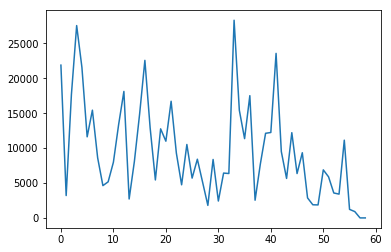

In [106]:
#SPLIT POINTS IN LAYERS
splitPoints_layers = np.zeros(len(layers))

channelIdx = 0
for layerIndx in range(0,len(layers)):
    nbrOfChannels = int(layers[idx].shape[3])
    splitPoints_layers[layerIndx] = np.average(splitPoints[channelIdx:(channelIdx+nbrOfChannels)])
    channelIdx +=nbrOfChannels
    print("Layer " + str(layerIndx) + " " + layer_names[layerIndx] + " split point: " + str(splitPoints_layers[layerIndx]))

plt.plot(splitPoints_layers)

In [105]:
layer_names[0]

u'import/conv2d0_pre_relu/conv'

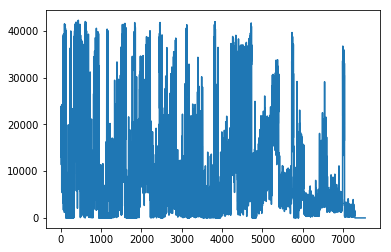

In [104]:
plt.plot(splitPoints)

In [121]:
#GET THE MAXIMUM ACTIVATIONS OF A CHANNEL WHICH ARE HIGHER THAN THRESHOLD*MAX(ACTIVATIONS) 
import matplotlib.pyplot as plt

nbr_classes = 1000
activationThr = 0.5

highActivations = []
topActivationsOfChannels = []

for channelNbr in range(0,all_activation.shape[1]):

    channelActivations = all_activation[:,channelNbr]
    maxActivations = np.sort(channelActivations)[::-1]
    maxActivationsIndexes = np.argsort(channelActivations)
    
    index =0
    activation = maxActivations[index]
    while activation < max(maxActivations)*activationThr:
        highActivations.append(index)
        index +=1
        activation = maxActivations[index]

    maxActivationClasses = grountTruth[highActivations]
    
    classActivations,bins = np.histogram(maxActivationClasses,bins=nbr_classes)
    print("Channel number: " + str(channelNbr) + " Max activation class: " + str(max(classActivations)))
       
    #if(max(maxActivationClasses)>10):
    #   topActivationsOfChannels[channelNbr,:] = classActivations
        

Channel number: 0 Max activation class: 0
Channel number: 1 Max activation class: 0
Channel number: 2 Max activation class: 0
Channel number: 3 Max activation class: 0
Channel number: 4 Max activation class: 0
Channel number: 5 Max activation class: 0
Channel number: 6 Max activation class: 0
Channel number: 7 Max activation class: 0
Channel number: 8 Max activation class: 0
Channel number: 9 Max activation class: 0
Channel number: 10 Max activation class: 0
Channel number: 11 Max activation class: 0
Channel number: 12 Max activation class: 0
Channel number: 13 Max activation class: 0
Channel number: 14 Max activation class: 0
Channel number: 15 Max activation class: 0
Channel number: 16 Max activation class: 0
Channel number: 17 Max activation class: 0
Channel number: 18 Max activation class: 0
Channel number: 19 Max activation class: 0
Channel number: 20 Max activation class: 0
Channel number: 21 Max activation class: 0
Channel number: 22 Max activation class: 0
Channel number: 23 Ma

Channel number: 196 Max activation class: 0
Channel number: 197 Max activation class: 0
Channel number: 198 Max activation class: 0
Channel number: 199 Max activation class: 0
Channel number: 200 Max activation class: 0
Channel number: 201 Max activation class: 0
Channel number: 202 Max activation class: 0
Channel number: 203 Max activation class: 0
Channel number: 204 Max activation class: 0
Channel number: 205 Max activation class: 0
Channel number: 206 Max activation class: 0
Channel number: 207 Max activation class: 0
Channel number: 208 Max activation class: 0
Channel number: 209 Max activation class: 0
Channel number: 210 Max activation class: 0
Channel number: 211 Max activation class: 0
Channel number: 212 Max activation class: 0
Channel number: 213 Max activation class: 0
Channel number: 214 Max activation class: 0
Channel number: 215 Max activation class: 0
Channel number: 216 Max activation class: 0
Channel number: 217 Max activation class: 0
Channel number: 218 Max activati

Channel number: 393 Max activation class: 0
Channel number: 394 Max activation class: 0
Channel number: 395 Max activation class: 0
Channel number: 396 Max activation class: 0
Channel number: 397 Max activation class: 0
Channel number: 398 Max activation class: 0
Channel number: 399 Max activation class: 0
Channel number: 400 Max activation class: 0
Channel number: 401 Max activation class: 0
Channel number: 402 Max activation class: 0
Channel number: 403 Max activation class: 0
Channel number: 404 Max activation class: 0
Channel number: 405 Max activation class: 0
Channel number: 406 Max activation class: 0
Channel number: 407 Max activation class: 0
Channel number: 408 Max activation class: 0
Channel number: 409 Max activation class: 0
Channel number: 410 Max activation class: 0
Channel number: 411 Max activation class: 0
Channel number: 412 Max activation class: 0
Channel number: 413 Max activation class: 0
Channel number: 414 Max activation class: 0
Channel number: 415 Max activati

Channel number: 595 Max activation class: 0
Channel number: 596 Max activation class: 0
Channel number: 597 Max activation class: 0
Channel number: 598 Max activation class: 0
Channel number: 599 Max activation class: 0
Channel number: 600 Max activation class: 0
Channel number: 601 Max activation class: 0
Channel number: 602 Max activation class: 0
Channel number: 603 Max activation class: 0
Channel number: 604 Max activation class: 0
Channel number: 605 Max activation class: 0
Channel number: 606 Max activation class: 0
Channel number: 607 Max activation class: 0
Channel number: 608 Max activation class: 0
Channel number: 609 Max activation class: 0
Channel number: 610 Max activation class: 0
Channel number: 611 Max activation class: 0
Channel number: 612 Max activation class: 0
Channel number: 613 Max activation class: 0
Channel number: 614 Max activation class: 0
Channel number: 615 Max activation class: 0
Channel number: 616 Max activation class: 0
Channel number: 617 Max activati

Channel number: 800 Max activation class: 0
Channel number: 801 Max activation class: 0
Channel number: 802 Max activation class: 0
Channel number: 803 Max activation class: 0
Channel number: 804 Max activation class: 0
Channel number: 805 Max activation class: 0
Channel number: 806 Max activation class: 0
Channel number: 807 Max activation class: 0
Channel number: 808 Max activation class: 0
Channel number: 809 Max activation class: 0
Channel number: 810 Max activation class: 0
Channel number: 811 Max activation class: 0
Channel number: 812 Max activation class: 0
Channel number: 813 Max activation class: 0
Channel number: 814 Max activation class: 0
Channel number: 815 Max activation class: 0
Channel number: 816 Max activation class: 0
Channel number: 817 Max activation class: 0
Channel number: 818 Max activation class: 0
Channel number: 819 Max activation class: 0
Channel number: 820 Max activation class: 0
Channel number: 821 Max activation class: 0
Channel number: 822 Max activati

Channel number: 1001 Max activation class: 0
Channel number: 1002 Max activation class: 0
Channel number: 1003 Max activation class: 0
Channel number: 1004 Max activation class: 0
Channel number: 1005 Max activation class: 0
Channel number: 1006 Max activation class: 0
Channel number: 1007 Max activation class: 0
Channel number: 1008 Max activation class: 0
Channel number: 1009 Max activation class: 0
Channel number: 1010 Max activation class: 0
Channel number: 1011 Max activation class: 0
Channel number: 1012 Max activation class: 0
Channel number: 1013 Max activation class: 0
Channel number: 1014 Max activation class: 0
Channel number: 1015 Max activation class: 0
Channel number: 1016 Max activation class: 0
Channel number: 1017 Max activation class: 0
Channel number: 1018 Max activation class: 0
Channel number: 1019 Max activation class: 0
Channel number: 1020 Max activation class: 0
Channel number: 1021 Max activation class: 0
Channel number: 1022 Max activation class: 0
Channel nu

Channel number: 1191 Max activation class: 0
Channel number: 1192 Max activation class: 0
Channel number: 1193 Max activation class: 0
Channel number: 1194 Max activation class: 0
Channel number: 1195 Max activation class: 0
Channel number: 1196 Max activation class: 0
Channel number: 1197 Max activation class: 0
Channel number: 1198 Max activation class: 0
Channel number: 1199 Max activation class: 0
Channel number: 1200 Max activation class: 0
Channel number: 1201 Max activation class: 0
Channel number: 1202 Max activation class: 0
Channel number: 1203 Max activation class: 0
Channel number: 1204 Max activation class: 0
Channel number: 1205 Max activation class: 0
Channel number: 1206 Max activation class: 0
Channel number: 1207 Max activation class: 0
Channel number: 1208 Max activation class: 0
Channel number: 1209 Max activation class: 0
Channel number: 1210 Max activation class: 0
Channel number: 1211 Max activation class: 0
Channel number: 1212 Max activation class: 0
Channel nu

Channel number: 1376 Max activation class: 0
Channel number: 1377 Max activation class: 0
Channel number: 1378 Max activation class: 0
Channel number: 1379 Max activation class: 0
Channel number: 1380 Max activation class: 0
Channel number: 1381 Max activation class: 0
Channel number: 1382 Max activation class: 0
Channel number: 1383 Max activation class: 0
Channel number: 1384 Max activation class: 0
Channel number: 1385 Max activation class: 0
Channel number: 1386 Max activation class: 0
Channel number: 1387 Max activation class: 0
Channel number: 1388 Max activation class: 0
Channel number: 1389 Max activation class: 0
Channel number: 1390 Max activation class: 0
Channel number: 1391 Max activation class: 0
Channel number: 1392 Max activation class: 0
Channel number: 1393 Max activation class: 0
Channel number: 1394 Max activation class: 0
Channel number: 1395 Max activation class: 0
Channel number: 1396 Max activation class: 0
Channel number: 1397 Max activation class: 0
Channel nu

Channel number: 1575 Max activation class: 0
Channel number: 1576 Max activation class: 0
Channel number: 1577 Max activation class: 0
Channel number: 1578 Max activation class: 0
Channel number: 1579 Max activation class: 0
Channel number: 1580 Max activation class: 0
Channel number: 1581 Max activation class: 0
Channel number: 1582 Max activation class: 0
Channel number: 1583 Max activation class: 0
Channel number: 1584 Max activation class: 0
Channel number: 1585 Max activation class: 0
Channel number: 1586 Max activation class: 0
Channel number: 1587 Max activation class: 0
Channel number: 1588 Max activation class: 0
Channel number: 1589 Max activation class: 0
Channel number: 1590 Max activation class: 0
Channel number: 1591 Max activation class: 0
Channel number: 1592 Max activation class: 0
Channel number: 1593 Max activation class: 0
Channel number: 1594 Max activation class: 0
Channel number: 1595 Max activation class: 0
Channel number: 1596 Max activation class: 0
Channel nu

KeyboardInterrupt: 

853
401


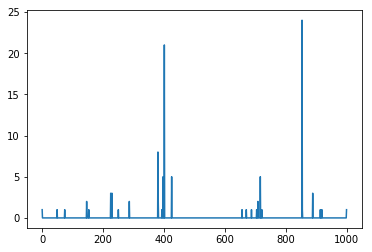

In [80]:
#EVALUATE HIGH ACTIVATION CHANNELS
topActivationsOfChannels.shape

channel = 7415

plt.plot(topActivationsOfChannels[channel,:])
firstmax = np.argmax(topActivationsOfChannels[channel,:])
topActivationsOfChannels[channel,firstmax] = 0
secondmax = np.argmax(topActivationsOfChannels[channel,:])
print(firstmax)
print(secondmax)


In [15]:
#SHOW IMAGE

imageID = 2130
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

image_names = os.listdir(img_dir)
image_names = sorted(image_names)

img_path = img_dir + image_names[imageID]

label = classNames[int(grountTruth[imageID])]
print("Image class:" + label)

im = Image.open(img_path)
im.show()



Image class:green snake


In [64]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)``
    using the default line style and color.
    
    If not used wi

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))
for idx in range(0,len(layers)):
    print('\n Feature layer: ' + str(layers[idx]) + ' nbr of channels: '+ str(feature_nums[idx]))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548

 Feature layer: import/conv2d0_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d1_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d2_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3a_1x1_pre_relu/conv nbr of channels: 64

 Feature layer: import/mixed3a_3x3_bottleneck_pre_relu/conv nbr of channels: 96

 Feature layer: import/mixed3a_3x3_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3a_5x5_bottleneck_pre_relu/conv nbr of channels: 16

 Feature layer: import/mixed3a_5x5_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3a_pool_reduce_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3b_1x1_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_bottleneck_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3b_5x5_bottleneck_pre_relu/conv nbr of

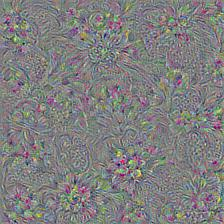

In [4]:


# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        
        #print(str(g))
        #input("next")
        
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:,:,:,channel])